In [1]:
# Matthew Lett
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, extract

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)
# reflect the tables

In [7]:
# We can view all of the classes that automap found
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the date and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

In [11]:
# Latest date
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

max_date

('2017-08-23',)

In [12]:
# Calculate the date 1 year ago from the last data point in the database
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)

one_year_ago

datetime.date(2016, 8, 23)

In [13]:
# Perform a query to retrieve the date and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# precipitation_data

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_data, columns=["date","precipitation"])
precipitation_df.set_index("date", inplace=True,)
precipitation_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Sort the dataframe by date
precipitation_df.sort_values('date')

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
...,...
2017-08-22,0.50
2017-08-23,0.08
2017-08-23,0.00


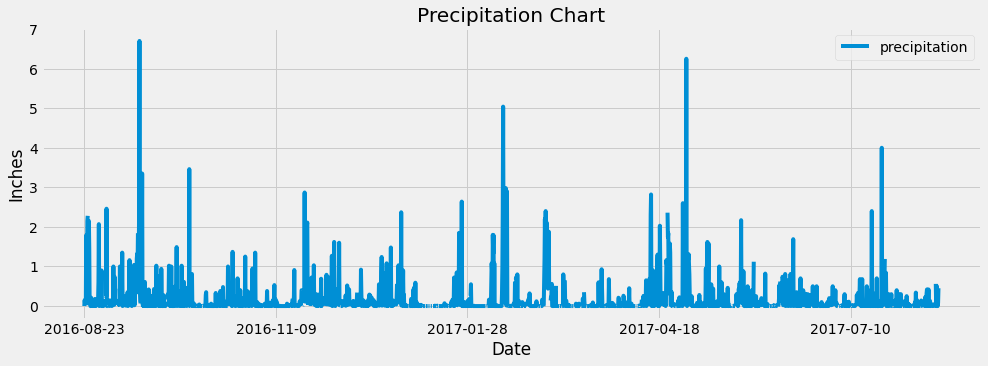

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(title='Precipitation Chart', figsize=(15,5), xlabel='Date', ylabel='Inches')
plt.savefig("Images/Percipitation_Chart.jpg")
plt.show()

In [18]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station).count()
print(f'There are {station_count} stations reporting')

There are 9 stations reporting


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).all()

most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

sel = [Measurement.station,
       func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]

temperature_results = session.query(*sel).filter(Measurement.station == 'USC00519281').all()

# temperature_results

temp_results_df=pd.DataFrame(temperature_results, columns=['station','min_temp', 'max_temp', 'avg_temp'])
temp_results_df.set_index('station', inplace=True)
temp_results_df

,min_temp,max_temp,avg_temp
station,,,
USC00519281,54.0,85.0,71.663781


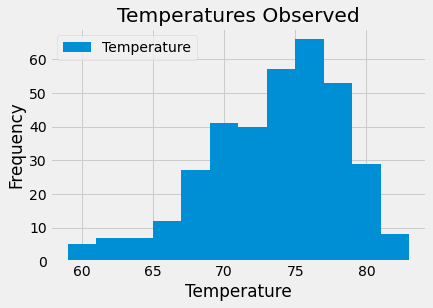

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_data = session.query(Measurement.tobs).\
            filter(Measurement.station == 'USC00519281').\
            filter(Measurement.date >= one_year_ago)

tobs_df = pd.DataFrame(tobs_data, columns=["Temperature"])

tobs_df.plot.hist(bins=12, title='Temperatures Observed')
plt.xlabel('Temperature')
plt.savefig('Images/Temperatures_Observered.jpg')
plt.show()

## Bonus Challenge Assignment

## Temperature Analysis 1

In [22]:
# Retrieve June and December temperatures and place them into dataframes

sel = [Measurement.date,Measurement.tobs]
june_temperatures = session.query(*sel).filter(func.strftime('%m', Measurement.date) == '06').all()
dec_temperatures = session.query(*sel).filter(func.strftime('%m', Measurement.date) == '12').all()

june_df = pd.DataFrame(june_temperatures,columns=["Date","Temperature"])
dec_df = pd.DataFrame(dec_temperatures,columns=["Date","Temperature"])

# The average temperature in June, and the average temperature in December 
june_avg = june_df["Temperature"].mean()
dec_avg = dec_df["Temperature"].mean()
print(f'The Average temperature in June is {round(june_avg, 2)}')
print(f'The Average temperature in December is {round(dec_avg, 2)}')

The Average temperature in June is 74.94
The Average temperature in December is 71.04


In [23]:
print(june_df['Temperature'].count())
print(dec_df['Temperature'].count())

1700
1517


In [24]:
import scipy.stats as stats

stats.ttest_ind(june_df['Temperature'], dec_df['Temperature'])

# Since we do not have matching lengths we will be using an unpaired t-test
# A large p-value (> 0.05) indicates weak evidence against the null hypothesis, so you fail to reject the null hypothesis.
# Based on the pvalue we can conclude that there is a significant difference in temperatures between June and December

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2017-07-01'
end_date = '2017-07-14'
calulate_temps = calc_temps(start_date, end_date)
temps_df = pd.DataFrame(calulate_temps, columns=['tmin', 'tavg', 'tmax'])
temps_df.head()

,tmin,tavg,tmax
0,69.0,78.116279,87.0


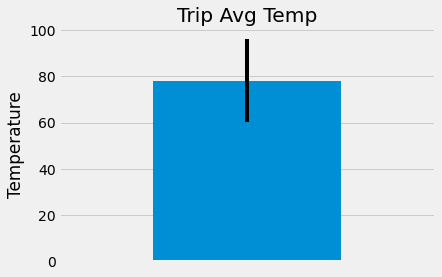

In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

ax = temps_df['tavg'].plot.bar(yerr=(temps_df['tmax']-temps_df['tmin']), title='Trip Avg Temp', ylabel = 'Temperature')
ax.axes.get_xaxis().set_visible(False)
plt.show()
ax.figure.savefig('Images/Average_Trip_Temperature.jpg')

In [28]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [Measurement.station, 
       func.sum(Measurement.prcp),
       Station.name,
       Station.latitude,
       Station.longitude,
       Station.elevation
      ]

station_totals = session.query(*sel).\
        filter(Measurement.station == Station.station, func.strftime(Measurement.date) >= start_date, func.strftime(Measurement.date) <= end_date) \
        .group_by(Measurement.station) \
        .order_by(func.sum(Measurement.prcp).desc()).all()

station_totals

[('USC00516128', 2.7700000000000005, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('USC00519281', 1.59, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00513117', 0.8, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00514830', 0.38, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 ('USC00519397', 0.21, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00519523', 0.13, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 ('USC00517948', None, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [30]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
# start_date
# end_date

# Use the start and end date to create a range of dates
date_range = pd.date_range(start_date, end_date).tolist()

# Stip off the year and save a list of %m-%d strings
trip_dates = []
for date in date_range:
    trip_dates.append(date.strftime('%m-%d'))

# # Loop through the list of %m-%d strings and calculate the normals for each date
normals=[]
for value in trip_dates:
    normals.append(daily_normals(value)[0])

normals

[(67.0, 74.77777777777777, 81.0),
 (68.0, 75.40384615384616, 82.0),
 (68.0, 75.32075471698113, 87.0),
 (70.0, 76.57142857142857, 81.0),
 (66.0, 75.0, 81.0),
 (69.0, 75.0, 81.0),
 (69.0, 74.91071428571429, 82.0),
 (69.0, 76.08333333333333, 83.0),
 (68.0, 76.19298245614036, 83.0),
 (68.0, 75.62068965517241, 82.0),
 (70.0, 75.78947368421052, 81.0),
 (67.0, 75.96491228070175, 82.0),
 (69.0, 76.1896551724138, 81.0),
 (61.0, 76.2280701754386, 82.0)]

In [31]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=['min_temp','avg_temp','max_temp'],index=trip_dates)
normals_df.index.name='date'
normals_df

,min_temp,avg_temp,max_temp
date,,,
07-01,67.0,74.777778,81.0
07-02,68.0,75.403846,82.0
07-03,68.0,75.320755,87.0
07-04,70.0,76.571429,81.0
07-05,66.0,75.000000,81.0
07-06,69.0,75.000000,81.0
07-07,69.0,74.910714,82.0
07-08,69.0,76.083333,83.0
07-09,68.0,76.192982,83.0


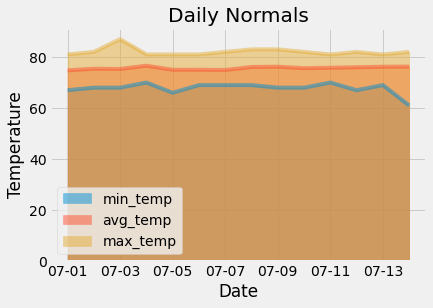

In [32]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Daily Normals')
plt.savefig('Images/Daily_Normals.jpg')
plt.show()